<a href="https://colab.research.google.com/github/rufimelo99/UltimatumGame/blob/main/UltimatumGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classes

## Player Class

In [132]:
import random
import numpy as np
import numpy.random as rnd
import math
from enum import Enum
bargainValues = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
mapValuesIndex = {0: 0, 0.1: 1, 0.2: 2, 0.3: 3, 0.4:4, 0.5: 5, 0.6: 6, 0.7: 7, 0.8: 8, 0.9: 9, 1: 10}
mapIndexValues = {0: 0, 1: 0.1, 2: 0.2, 3: 0.3, 4:0.4, 5: 0.5, 6: 0.6, 7: 0.7, 8: 0.8, 9: 0.9, 10: 1}

class PlayerRole(Enum):
    EMPATHIC = 1
    PRAGMATIC = 2
    INDEPENDENT = 3

class Player:
    def __init__(self, id, PlayerRole) -> None:
        self.id=id
        self.neighbours = []
        self.ComulativePayoff = 0
        self.gamesPlayed = 0

        self.pValue=0
        self.qValue=0
        self.PlayerRole=PlayerRole

        self.probUsingNeighbourStategy=0
        self.usingNeighbourStategy = False
        self.NeighbourPValue = 0
        self.NeighbourQValue = 0

    def attributeStrategy(self):
      if self.PlayerRole == PlayerRole.EMPATHIC :
        self.pValue = random.choice(bargainValues)
        self.qValue = self.pValue
      elif self.PlayerRole == PlayerRole.PRAGMATIC :
        self.pValue = random.choice(bargainValues)
        self.qValue = 1-self.pValue
      elif self.PlayerRole == PlayerRole.INDEPENDENT :
        self.pValue = random.choice(bargainValues)
        self.qValue = random.choice(bargainValues)



    def makeOffer(self):
        #returns index of bargain proposal 
        #offer from Proposer
        if self.usingNeighbourStategy:

          prob = self.probUsingNeighbourStategy
          usingExternalPolicy = rnd.choice([0, 1], p = [1-prob, prob])
          
          if usingExternalPolicy:
            return mapValuesIndex[self.NeighbourPValue]
          else:
            return mapValuesIndex[self.pValue]
        else:
          return mapValuesIndex[self.pValue]

    def bargainDecision(self, bargainValueIndex):
        if self.usingNeighbourStategy:
          prob = self.probUsingNeighbourStategy
          usingExternalPolicy = rnd.choice([0, 1], p = [1-prob, prob])
          if usingExternalPolicy:
            if mapIndexValues[bargainValueIndex]>=self.NeighbourQValue:
              return 1
            else:
              return 0
        else:
          if mapIndexValues[bargainValueIndex]>=self.qValue:
            return 1
          else:
            return 0
        if mapIndexValues[bargainValueIndex]>=self.qValue:
          return 1
        else:
          return 0 


## Ultimaum Game Class

In [141]:
import networkx as nx
import matplotlib.pyplot as plt

stopsForGraphs = [1,10,100,1000,10000, 20000]

class ultimatumGame:
  
    def __init__(self, Nplayers, PlayerRole, ScaleFree=False) -> None:
        
        if ScaleFree:
          #Scale-Free
          #nooo
          #self.graph = nx.complete_graph(Nplayers)
          self.graph = nx.scale_free_graph(Nplayers)
          #self.graph = random_powerlaw_tree_sequence(Nplayers)
        else:
          #Erdos-Renyi
          self.graph = nx.erdos_renyi_graph(Nplayers, 0.15)

        self.Players = {}
        
        #uniforms distributions i gueess TODO
        pValuesForAll = random.choices (bargainValues,k=Nplayers)
        #if needed
        qValuesForAll = random.choices (bargainValues,k=Nplayers)

        #create all players
        for i in range(Nplayers):
            player = Player(i, PlayerRole)
            player.neighbours = list(self.graph.adj[i])

            if PlayerRole == PlayerRole.EMPATHIC :
              player.pValue = pValuesForAll[i]
              player.qValue = player.pValue
            elif PlayerRole == PlayerRole.PRAGMATIC :
              player.pValue = pValuesForAll[i]
              player.qValue = 1-player.pValue
            elif PlayerRole == PlayerRole.INDEPENDENT :
              player.pValue = pValuesForAll[i]
              player.qValue = qValuesForAll[i]


            self.Players[i]=player

    def printGraph(self):
        #nx.draw_shell(self.graph, with_labels = True)
        #nx.draw(self.graph, with_labels = True)
        
        fig = plt.figure(figsize=(40, 40)) 
        nx.draw(self.graph, node_size=150, with_labels = True) 
        plt.axis('equal') 
        plt.show() 
        plt.show()

    def runEpisode(self, actualIteration,offersDicInitial,offerDic,stopsForGraphs, SocialPenalty=True):
      for playerId in range(len(self.Players)):
        #natural selection -> see if there is a better policy
        player = self.Players[playerId]
        if player.neighbours!=[]:
          #see if my random neighbour has a better startegy
          randomNeighbourIndex = rnd.choice(len(player.neighbours))
          randomNeighbourId = player.neighbours[randomNeighbourIndex]
          randomNeighbour = self.Players[randomNeighbourId]
          if randomNeighbour.ComulativePayoff > player.ComulativePayoff and actualIteration != 1:
            #see here
            if len(player.neighbours)>len(randomNeighbour.neighbours):
              higherDegree=len(player.neighbours)
            else:
              higherDegree=len(randomNeighbour.neighbours)

            probUsingNeighbourStategy = round(((randomNeighbour.ComulativePayoff-player.ComulativePayoff)/ (2*higherDegree)),3)
              
            player.usingNeighbourStategy = True
            player.probUsingNeighbourStategy = probUsingNeighbourStategy
            player.NeighbourQValue = randomNeighbour.qValue
            player.NeighbourPValue = randomNeighbour.pValue

        #episode itself    
        for neighbourId in self.Players[playerId].neighbours:
          player = self.Players[playerId]
          neighbour = self.Players[neighbourId]
          
          playerBargainIndex=player.makeOffer()
          rewardAcceptedOrNot = neighbour.bargainDecision(playerBargainIndex)
          
          playerReward = bargainValues[-(playerBargainIndex+1)]
          neighbourReward = bargainValues[playerBargainIndex]
          
          #add payoffs to player  
          player.ComulativePayoff+=rewardAcceptedOrNot*playerReward
          neighbour.ComulativePayoff+=rewardAcceptedOrNot*neighbourReward
          player.gamesPlayed += 1
          neighbour.gamesPlayed += 1

                  
          #TODO might be wrong.. must be.. jesus
          offersDicInitial[bargainValues[playerBargainIndex]]+=1
      

      #save data for graphs
      if actualIteration in stopsForGraphs:
        offerDic[actualIteration]=offersDicInitial.copy()
        offersDicInitial.update({}.fromkeys(offersDicInitial,0))
      

      #get the comulative payoffs after a round-robin round
      lowerPayoff = 1.0
      lowerPayoffId = 0
      for playerId in range(len(self.Players)):
        player = self.Players[playerId]
        if player.neighbours!=[]:
          
          #reseting payoffs of that round
          player.ComulativePayoff = 0
          player.gamesPlayed = 0
          #updating lowerPayoff if necessary
          if player.ComulativePayoff<lowerPayoff:
            lowerPayoff=player.ComulativePayoff
            lowerPayoffId=player.id
            
        
        #reset natural Selection
        player.usingNeighbourStategy = False
        
      #Social penalty
      #TODO
      #see neigbours policy->comunidaades
      if SocialPenalty:
        playerToBeRemoved = self.Players[lowerPayoffId]
        #handle its neighbours
        for i in playerToBeRemoved.neighbours:
          #update its q and p values     
          self.Players[i].attributeStrategy()

        #update q and p Values
        playerToBeRemoved.attributeStrategy()


      return offersDicInitial,offerDic
          

# Execution

## Game Creation


## Running Game

### Test

iteration: 0
iteration: 10
iteration: 20
iteration: 30
iteration: 40
iteration: 50
iteration: 60
iteration: 70
iteration: 80
iteration: 90
iteration: 100
iteration: 110
iteration: 120
iteration: 130
iteration: 140
iteration: 150
iteration: 160
iteration: 170
iteration: 180
iteration: 190
iteration: 200
iteration: 210
iteration: 220
iteration: 230
iteration: 240
iteration: 250
iteration: 260
iteration: 270
iteration: 280
iteration: 290
iteration: 300
iteration: 310
iteration: 320
iteration: 330
iteration: 340
iteration: 350
iteration: 360
iteration: 370
iteration: 380
iteration: 390
iteration: 400
iteration: 410
iteration: 420
iteration: 430
iteration: 440
iteration: 450
iteration: 460
iteration: 470
iteration: 480
iteration: 490
iteration: 500
iteration: 510
iteration: 520
iteration: 530
iteration: 540
iteration: 550
iteration: 560
iteration: 570
iteration: 580
iteration: 590
iteration: 600
iteration: 610
iteration: 620
iteration: 630
iteration: 640
iteration: 650
iteration: 660
iterat

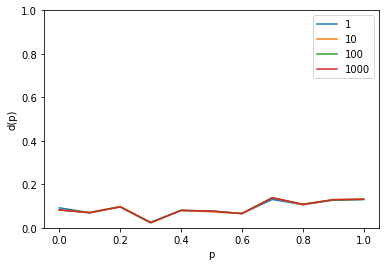

In [146]:
NPLAYERS =  101
NITERATIONS = 1001

game = ultimatumGame(NPLAYERS, PlayerRole.PRAGMATIC, ScaleFree=False)


offersDicInitial={0:0, 0.1:0, 0.2:0, 0.3:0, 0.4:0, 0.5:0, 0.6:0, 0.7:0, 0.8:0, 0.9:0, 1:0}
offerDic = {}
stopsForGraphs = [1,10,100,1000,10000,20000]

#run episodes
for iteration in range(NITERATIONS):
  if iteration%10==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic = game.runEpisode(iteration,offersDicInitial,offerDic,stopsForGraphs, SocialPenalty=False)

plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[1].values())) /sum(np.array(list(offerDic[1].values()))) , label = "1" ) 
plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[10].values()))/sum(np.array(list(offerDic[10].values()))), label = "10")
plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))), label = "100")
plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))), label = "1000")
#plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))), label = "10000")
#plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[20000].values()))/sum(np.array(list(offerDic[20000].values()))), label = "20000")


# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()



# extra

In [147]:
print(np.array(list(offerDic[1].values())))
print(np.array(list(offerDic[1].values())) /sum(np.array(list(offerDic[1].values()))))
print(np.array(list(offerDic[10].values())))
print(np.array(list(offerDic[10].values())) /sum(np.array(list(offerDic[10].values()))))
print(np.array(list(offerDic[100].values())))
print(np.array(list(offerDic[100].values())) /sum(np.array(list(offerDic[100].values()))))
#print(np.array(list(offerDic[100].values())))
#print(np.array(list(offerDic[100].values())) /sum(np.array(list(offerDic[100].values()))))

[285 217 301  80 247 239 203 405 330 394 403]
[0.09181701 0.06990979 0.09697165 0.0257732  0.07957474 0.07699742
 0.06539948 0.1304768  0.10631443 0.12693299 0.12983247]
[1148  995 1371  330 1124 1025  914 1931 1478 1815 1837]
[0.08218786 0.07123425 0.09815292 0.02362543 0.08046964 0.07338202
 0.06543528 0.13824456 0.10581329 0.12993986 0.13151489]
[11498  9676 13446  3264 11191 10769  9150 19277 15147 17960 18302]
[0.08231672 0.06927262 0.09626289 0.0233677  0.08011884 0.07709765
 0.06550687 0.1380083  0.10844072 0.12857961 0.13102806]


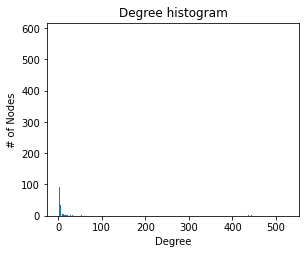

In [ ]:
degree_sequence = sorted([d for n, d in game.graph.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [ ]:
for playerId in range(len(game.Players)):
  player = game.Players[playerId]
  print("player id: "+str(player.id))
  print("qinitProposer")
  print(player.qinitProposer)
  print("qinitCorrespondent")
  print(player.qinitCorrespondent)

print(list(offerDic[1].values()))

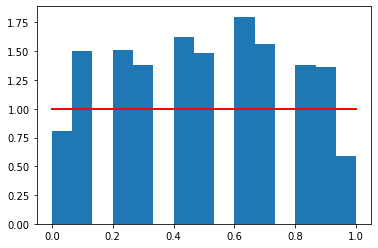

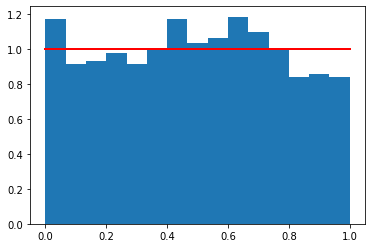

In [ ]:
s = np.random.uniform(0,1,1000)
ola = [round(i,1) for i in list(s) ]
count, bins, ignored = plt.hist(ola, 15, density=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()

count, bins, ignored = plt.hist(s, 15, density=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()

Counter({0.3: 110, 0.5: 103, 0: 97, 0.6: 94, 1.0: 91, 0.9: 90, 0.1: 89, 0.7: 87, 0.8: 86, 0.4: 79, 0.2: 74})


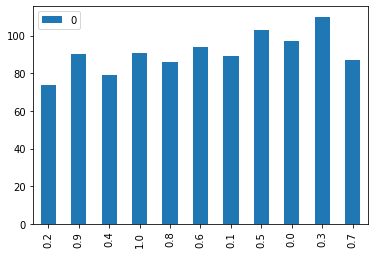

In [ ]:
from collections import Counter
import pandas
ran = random.choices (bargainValues,k=1000)
count = Counter(ran)
print(count)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

Ver se natural selection ]e com base no avg payoff ou global
se na formula os k sao os graus dos nos *a.ka. vizinhos_
ver scale free undirected
perceber o que é o d(p)